In [17]:
import os
import io
import json
import hashlib
import random
from typing import Dict, List

In [2]:
import numpy as np
import PIL
import PIL.Image

import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [4]:
from train import fetch_image_data

In [5]:
metadata_filepath = 'metadata.json'
packed_image_filepath = 'images.bin'
labeling_filepath = 'japanese-characters.txt'

In [6]:
labeling_content = open(labeling_filepath, mode='rb').read()

# hash label file for identifying if the trained model is compatible with a specific label file
label_file_hash = hashlib.sha256(labeling_content).hexdigest()

labeling_content = labeling_content.decode('utf-8')

labeling_lines = labeling_content.splitlines()
labeling_lines = list(filter(lambda x: len(x) > 0, labeling_lines))

label_list = []
for line in labeling_lines:
    rows = line.split('\t')
    if len(rows) > 1:
        main_label_chars = rows[0]
        sub_label_chars = rows[1]
        label_chars = main_label_chars + sub_label_chars
    else:
        main_label_chars = rows[0]
        sub_label_chars = ''
        label_chars = main_label_chars

    label_entry = {
        'label_chars': label_chars,
        'main_label_chars': main_label_chars,
        'sub_label_chars': sub_label_chars,
    }

    label_list.append(label_entry)

label_to_index = {}

num_outputs = len(label_list)

for i in range(num_outputs):
    label_chars = label_list[i]['label_chars']

    for c in label_chars:
        if c in label_to_index:
            raise Exception(f'Duplicated character {c}!')
        else:
            label_to_index[c] = i

####################################################################

metadata_content = open(metadata_filepath, mode='rb').read()
metadata_content = metadata_content.decode('utf-8')

dataset_metadata: Dict[str, List[dict]] = json.loads(metadata_content)
records = dataset_metadata['records']
fetch_image_data(records, packed_image_filepath)

train_images = []
train_labels = []

input_shape = (64, 64, 1)

for record in records:
    label_char = record['char']
    image_bs: bytes = record['image_data']

    label_idx = label_to_index[label_char]
    train_labels.append(label_idx)

    buffer = io.BytesIO(image_bs)
    pil_image = PIL.Image.open(buffer)
    np_image = np.array(pil_image, dtype=np.float32)
    np_image = np_image / 255.0
    np_image = np.reshape(np_image, input_shape)
    train_images.append(np_image)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
num_records = len(train_labels)

769 {'label_chars': '忘', 'main_label_chars': '忘', 'sub_label_chars': ''}


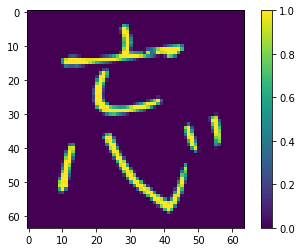

In [22]:
idx = random.randrange(num_records)
img = train_images[idx,:,:,0]
label_idx = train_labels[idx]

print(label_idx, label_list[label_idx])
plt.imshow(img)
plt.colorbar()

In [8]:
model_filepath = 'model_checkpoints-20201008_211403/finished_training_model-epoch_20.h5'
model = tf.keras.models.load_model(model_filepath)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 32)        8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        131136    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [9]:
evaluated_outputs = model.predict(x=train_images)
type(evaluated_outputs)

numpy.ndarray

In [10]:
evaluated_outputs.shape

(104449, 2214)

In [14]:
np.argmax(evaluated_outputs[100000])

0

label: 417 {'label_chars': '哲', 'main_label_chars': '哲', 'sub_label_chars': ''}
output: 0 {'label_chars': 'あぁ', 'main_label_chars': 'あ', 'sub_label_chars': 'ぁ'}


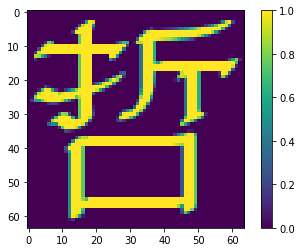

In [55]:
idx = random.randrange(num_records)
img = train_images[idx,:,:,0]
label_idx = train_labels[idx]
output_array = evaluated_outputs[idx]
output_label_idx = np.argmax(output_array)

print('label:', label_idx, label_list[label_idx])
print('output:', output_label_idx, label_list[output_label_idx])
plt.imshow(img)
plt.colorbar()